# Data preprocessing
This notebook performs data preprocessing of ingredients data

In [1]:
# Python standard libraries
import ast
import pickle
import random
import re
from collections import Counter 

# third party imports
import h5py
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import style
plt.style.use('ggplot')
from tensorflow.keras.preprocessing.text import Tokenizer


# 1. Load & clean data

* data: <a href="https://www.kaggle.com/kaggle/recipe-ingredients-dataset/">recipe-ingredients dataset</a> from Kaggle. The dataset was part of a competition for predicting the cuisine type given ingredients list. 
* I chose this dataset because I wanted my recommender system to address questions like "How do I cook my chicken in Indian style? Korean style?  
* I used just the training data of this dataset. If one was interested in building a recommender system for ingredients without considering the cuisine, one could use both the training and testing set of the Kaggle dataset. One can also extend the dataset by combining with other sources of recipe data  

## 1.1 Text cleanup

* Cleanups performed
    * Remove parentheses and characters between parentheses. This removes quantity information. ex) " (2 oz. ) tomato sauce"
    * Convert all strings into lowercase letters  
    * Replace spaces with underscore _   
 
* Remaining issues with the data after cleanup step
    * Some ingredients contain brand names of the ingredients.  
    * Some ingredients contain non-alphabet characters. Many of them seem to come from brand names.   
    * Some ingredients contain cooking instructions. Example: "spinach, thawed and squeezed dry"  

In [5]:
# load data
file_name = 'data/recipe-ingredients-dataset/train.json'

with open(file_name, 'r') as f:
    objects = ijson.items(f, 'item')
    data = list(objects)

df = pd.DataFrame(data)

In [9]:
# Look at data to figure out what kind of text cleaning we need to do

ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')

print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:20])
print(ing_list[-20:])

Example ingredients
['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '1%_low-fat_milk' '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '2%_reduced-fat_milk'
 '25% less sodium chicken broth']
['young coconut meat' 'young leeks' 'young nettle' 'yu choy' 'yuca'
 'yucca' 'yucca root' 'yukon gold' 'yukon gold potatoes'
 'yukon_gold_potatoes' 'yuzu' 'yuzu juice' "za'atar" 'zest'
 'zesty italian dressing' 'zesty_italian_dressing' 'zinfandel' 'ziti'
 'zucchini' 'zucchini blossoms']


In [10]:
# Remove characters between (and including) parentheses
# Turn all strings into lowercase  
# Replace spaces with underscore. 

for i in df.index:
    ing = df.at[i,'ingredients']
    for j, item in enumerate(ing):
        
        # Replace all characters between parentheses
        if  ('(' in item) or (')' in item):
            item = re.sub('\s*\([^)]*\)\s*', '', item)
            ing[j] = item
        
        # Turn all Upper case into lowercase
        ing[j] = item.lower()
        
        # replace spaces with underscore 
        ing[j] = ing[j].replace(' ','_')
        
    df.at[i,'ingredients'] = ing

## 1.2 Remove stop words

* stop words: ingredients that appear frequently throughout the documents.  
* Based on the frequency of ingredients, I removed "salt" from every document.

In [13]:
# get the list of ingredients
ing_list = df['ingredients'].tolist()
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

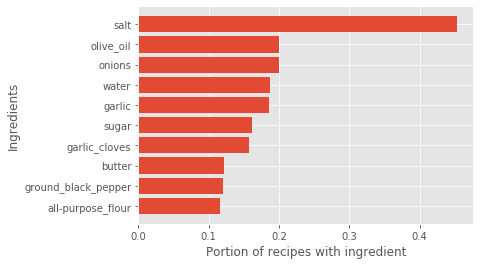

In [14]:
# Visualize top N most frequently used ingredients
N = 10

n_documents = df.shape[0]
frequent_ing = ing_by_count[:N]
prob_ing = [ing_count[item]/n_documents for item in frequent_ing]

plt.barh(frequent_ing[::-1], prob_ing[::-1])
plt.xlabel('Portion of recipes with ingredient')
plt.ylabel('Ingredients')
plt.title('')
plt.show()

The above graph shows that more than 40% of documents contain the ingredient "salt". I decided to remove the ingredient "salt" from all documents.

In [15]:
# Remove the ingredient "salt"
for i in range(df.shape[0]):
    ing = df.at[i,'ingredients']
    df.at[i,'ingredients'] = [item for item in ing if item != 'salt']

## 1.3 Create documents of ingredients and cuisine

In [16]:
# get list of ingredients and list of cuisine
ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')    
    
# add cleaned up ingredients + cuisine to dataframe
df['document'] = ingredients

In [18]:
# show dataframe
df.head()

,id,cuisine,ingredients,document
0,10259,greek,"[romaine_lettuce, black_olives, grape_tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,25693,southern_us,"[plain_flour, ground_pepper, tomatoes, ground_...","[plain_flour, ground_pepper, tomatoes, ground_..."
2,20130,filipino,"[eggs, pepper, mayonaise, cooking_oil, green_c...","[eggs, pepper, mayonaise, cooking_oil, green_c..."
3,22213,indian,"[water, vegetable_oil, wheat]","[water, vegetable_oil, wheat, indian]"
4,13162,indian,"[black_pepper, shallots, cornflour, cayenne_pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


In [17]:
# save dataframe
#df.to_csv('data/ingredient_recommendation/data.csv')

# 2. Preliminary analysis

## 2.1 Dataset bias 

* About 40,000 documents(recipes) involving 6700 ingredients 
* 20 different cuisine type
* Note the <b>potential bias</b>
    * Our dataset is biased: Some cuisine (like Italian and Mexican cuisine) are more frequently represented than some others (like Russian and brazilian cuisinze).  
    *  A recommender might recommend ingredients that go well together in mostly Italian and Mexican cuisine. 
    *  <b><font color='red'>To Do</font></b>: I might want to consider some tools for decreasing bias from my model. 

In [2]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
df = df.drop(df.columns[0], axis=1)

# Convert to format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [3]:
# number of documents and ingredients
ing_list = np.unique([item for recipes in documents for item in recipes])

print('total number of recipes: ', len(documents))
print('total number of ingredients: ', len(np.unique(ing_list)))

total number of recipes:  39774
total number of ingredients:  6712


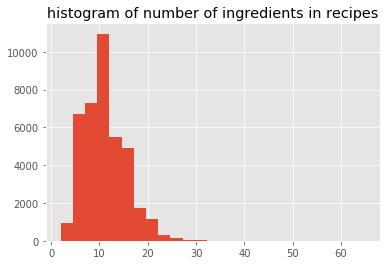

maximum number of ingredients in a given recipe:  65
minimum number of ingredients in a given recipe:  2


In [23]:
# Number of ingredients in each recipe
ing_len = [len(x) for x in documents]

plt.hist(ing_len, bins = 25)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

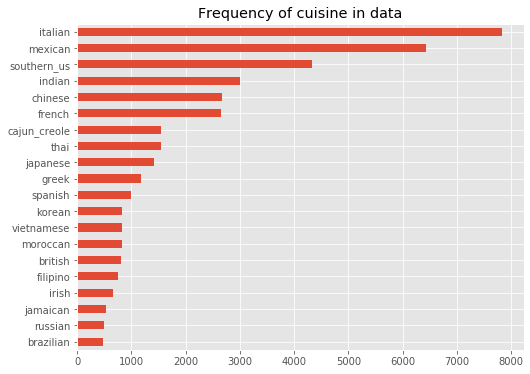

In [24]:
# Number of cuisine represented
df['cuisine'].value_counts(ascending = True).plot(kind = 'barh', figsize=(8,6))
plt.title('Frequency of cuisine in data')
plt.show()

<b> NOTE: POTENTIAL BIAS </b>
* The above graph indicates that our dataset is biased -- Italian and Mexican cuisine are represented much more than other types of cuisine.   
* One should be aware that any model trained on this dataset could potentially be biased.  
* In order to balance the number of documents in each cuisine, we'll perform <b> oversampling and undersampling in training data</b>

## 2.2 Training / CV / testing set

In [27]:
# Divide into training (70%), cross-validation (15%), and testing set (15%)
n_documents = df.shape[0]
print('total number of documents: ', n_documents)

total = list(range(n_documents))
random.shuffle(total)

train_size = int(n_documents * 0.7)
cv_size = int(n_documents * 0.15)
train_idx = total[:train_size]
cv_idx = total[train_size:train_size + cv_size]
test_idx = total[train_size + cv_size:]

print('number of training set: ', len(train_idx))
print('number of cross-validation set: ', len(cv_idx))
print('number of test set: ', len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
#f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'w')
#f.create_dataset("train_idx", data = train_idx)
#f.create_dataset("cv_idx", data = cv_idx)
#f.create_dataset("test_idx", data = test_idx)
#f.close()

total number of documents:  39774
number of training set:  27841
number of cross-validation set:  5966
number of test set:  5967


## 2.3 Fix training set bias via oversampling & undersampling

* Oversampling under-represented cuisine.  
* Undersampling over-represented cuisine. 

In [28]:
# open indices for train, CV, test set
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f["train_idx"])
cv_idx = list(f["cv_idx"])
test_idx = list(f["test_idx"])
f.close()

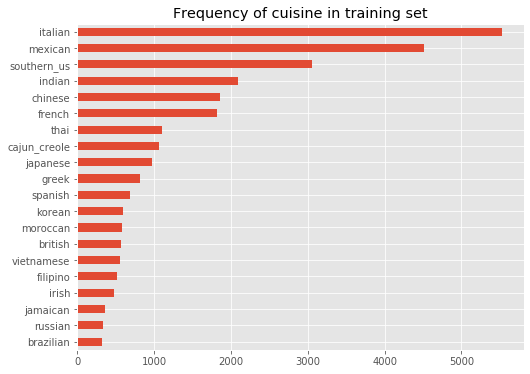

In [29]:
# Frequency of documents in each cuisine in training set
df_train = df.iloc[train_idx]
df_train.reset_index(drop = True, inplace = True)

df_train["cuisine"].value_counts(ascending = True).plot(kind = "barh", figsize = (8,6))
plt.title("Frequency of cuisine in training set")
plt.show()

Oversample documents whose cuisine count is less than X% of majority class.  
Oversample so that the count of such cuisine become X% of majority class

In [30]:
# Oversample documents whose cuisine count is less than "sampling_perc" of majority class
sampling_perc = 0.2 
df_train_balanced = df_train.copy()

# compute count
cuisine_train = df_train["cuisine"].value_counts()
majority_count = max(cuisine_train)

# find cuisine type that needs to be oversampled 
oversample = []
for (cuisine, value) in cuisine_train.items():
    if value < majority_count * sampling_perc:
        
        # find number of samples needed
        n_sample = int(majority_count * sampling_perc - value)
        
        # sample
        cuisine_idx = list(df_train_balanced[df_train_balanced.cuisine == cuisine].index)
        sampled_idx = np.random.choice(cuisine_idx, n_sample)
        
        # add sampled cuisine dataframe
        df_sampled = df_train_balanced.loc[sampled_idx]
        df_train_balanced = pd.concat([df_train_balanced, df_sampled], ignore_index = True)
        df_train_balanced.reset_index(drop = True, inplace = True )
        
        oversample.append(cuisine)
print('Cuisine types that were oversampled: ', oversample)

Cuisine types that were oversampled:  ['thai', 'cajun_creole', 'japanese', 'greek', 'spanish', 'korean', 'moroccan', 'british', 'vietnamese', 'filipino', 'irish', 'jamaican', 'russian', 'brazilian']


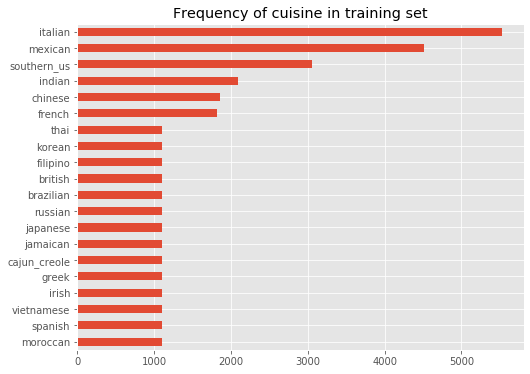

In [31]:
# Frequency of cuisine after oversampling
df_train_balanced["cuisine"].value_counts(ascending = True).plot(kind = "barh", figsize = (8,6))
plt.title("Frequency of cuisine in training set")
plt.show()

Undersample documents whose cuisine count is more than X% of minority class.  
Undersample so that count of such cuisine becomes X% of minority class

In [33]:
# Undersample documents whose cuisine count is more than "sampling_perc" * 100% of minority class
sampling_perc = 2

# Compute count of cuisine
cuisine_train = df_train_balanced["cuisine"].value_counts()
minority_count = min(cuisine_train)

# find cuisine that needs undersampling
undersample = []
for (cuisine, value) in cuisine_train.items():
    if value >= minority_count * sampling_perc:
        
        # determine how many samples are need to be removed
        n_sample = int(cuisine_train[cuisine] - minority_count * 2)
        
         # Sample 
        cuisine_idx = list(df_train_balanced[df_train_balanced.cuisine == cuisine].index)
        sampled_idx = np.random.choice(cuisine_idx, n_sample, replace = False)
        
         # drop rows 
        df_train_balanced.drop(sampled_idx, inplace = True)
        df_train_balanced.reset_index(drop = True, inplace = True)
        
        undersample.append(cuisine)
print("Cuisine types that were undersampled:", undersample)

# shuffle rows of dataframe
df_train_balanced = df_train_balanced.sample(frac = 1)

Cuisine types that were undersampled: ['italian', 'mexican', 'southern_us']


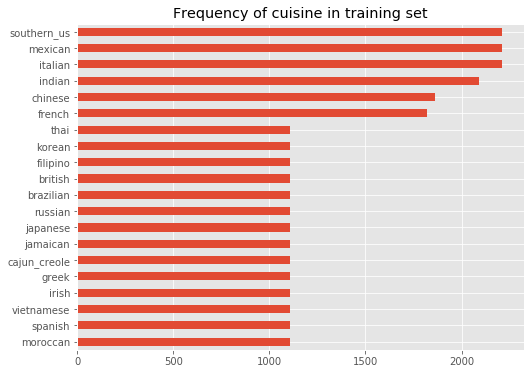

In [34]:
df_train_balanced["cuisine"].value_counts(ascending = True).plot(kind = "barh", figsize = (8,6))
plt.title("Frequency of cuisine in training set")
plt.show()

In [ ]:
# save balanced training data
#df_train_balanced.to_csv('data/ingredient_recommendation/balanced_training.csv')

## 2.4 Tokenize dataset

In [4]:
# load data if needed 
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))
# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [5]:
# tokenize
t=Tokenizer()  
t.fit_on_texts(documents)

# save tokenizer
#with open('models/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

tokenize the BALANCED train, CV, and test set

In [9]:
# save tokenized train, CV, test set
# NOTE: the indexing has been adjusted to start at 0. (keras tokenizer starts indexing at 1)

# load (balanced) training data
df_train = pd.read_csv('data/ingredient_recommendation/balanced_training.csv')
df_train.drop("Unnamed: 0", axis = 1, inplace = True)

# get training documents
train_doc = [ast.literal_eval(df_train.document[idx]) for idx in range(df_train.shape[0])]
train_t = t.texts_to_sequences(train_doc)
train_encoded = [[item-1 for item in doc] for doc in train_t]

cv_doc = [documents[i] for i in cv_idx]
cv_t = t.texts_to_sequences(cv_doc)
cv_encoded = [[item-1 for item in doc] for doc in cv_t]

test_doc = [documents[i] for i in test_idx]
test_t = t.texts_to_sequences(test_doc)
test_encoded = [[item-1 for item in doc] for doc in test_t]

In [34]:
# save encoded data
with open("data/ingredient_recommendation/train_encoded.csv", "wb") as f:
    pickle.dump(train_encoded ,f)
with open("data/ingredient_recommendation/cv_encoded.csv", "wb") as f:
    pickle.dump(cv_encoded ,f)
with open("data/ingredient_recommendation/test_encoded.csv", "wb") as f:
    pickle.dump(test_encoded ,f)

## 2.5 Metrics for evaluation 

* In order to compare the performance of multiple models, I decided on a common metric to evaluate the models.  
* Use evaluation metric for classification models      
* Precision, Recall, and F-scores 
    * Precision: Of all the predicted ingredients, how much were actually true ingredients? TP / (TP + FP)
    * Recall: Of all the true ingredients, how much did we predict correctly? TP/(TP + FN)   
    * F-score : (2 * recall * precision) / (recall + precision)    
    
* Possible option: Weigh the incorrect ingredients. For example, if an incorrect predicted ingredient is still considered "similar" to an existing ingredient (maybe using word embedding features), one can still account for the incorrect prediction as a true positive with a smaller weight than 1

In [35]:
def sample_ingredients(ing, n):  
    # For each document, sample "n" number of ingredients randomly.
    # (If a recipe involves fewer than "n" ingredients, ignore that recipe)
    # The sampled ingredients will serve as the existing ingredients to the recommender.
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients for a particular recipe
    n: (int) number of ingredients to be sampled
   
    --- output ---
    existing_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    missing_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    indices: (list) of indices of documents in "ing" that had more than "n" ingredients 
    """
    
    existing_ing = []
    missing_ing = []
    indices = []

    for idx, recipe in enumerate(ing):
        if len(recipe) > n:

            # sample "n" ingredients at random
            sampled = random.sample(recipe, n)
            remain = list(set(recipe)-set(sampled))

            existing_ing.append(sampled)
            missing_ing.append(remain)
            indices.append(idx)
    return existing_ing, missing_ing, indices

In [37]:
def compute_scores(predicted_ing, true_ing):
    # compute precision, recall, F-score

    """
    --- input ---
    predicted_ing: (list) of predicted ingredients from the model
    true_ing: (list) of true ingredients that needed to be predicted

    --- output ---
    predicion, recall, F_score
    """
    
    predicted_ing = set(predicted_ing)
    true_ing = set(true_ing)

    TP = len(predicted_ing.intersection(true_ing))

    if len(predicted_ing) != 0:
        precision = TP / (len(predicted_ing))
    else:
        precision = 0 
    recall = TP / len(true_ing)
    
    if recall != 0 and precision != 0:
        F_score = (2 * recall * precision)/(precision + recall)
    else:
        F_score = 0
    
    return precision, recall, F_score

In [38]:
# example 
precision, recall, F_score = compute_scores(['onions', 'scallions', 'bread'],
                                           ['scallions'])

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5
